# exp12: 厳密なモデル評価

**ベースライン**: exp11の特徴量と検証方法を使用

**改善点**:
- 各モデル(weightA, weightB, hist, extra, catboost)について:
  - 訓練直後に個別でMAE, RMSE, R2, WAPEを表示
  - 検証データとテストデータの両方で評価
- 最後に全モデルの評価指標を比較しやすい表形式で一覧表示

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters (from exp05 optimization)
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'RandomForest': {
        'n_estimators': 261,
        'max_depth': 21,
        'min_samples_split': 13,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'GradientBoosting': {
        'n_estimators': 477,
        'learning_rate': 0.26835579181051533,
        'max_depth': 2,
        'min_samples_split': 5,
        'min_samples_leaf': 1,
        'subsample': 0.9721678101451118
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'XGBoost': {
        'n_estimators': 4666,
        'learning_rate': 0.18057598957444881,
        'max_depth': 5,
        'subsample': 0.7726782988943871,
        'colsample_bytree': 0.6039221062901661,
        'reg_lambda': 0.9814360532884759,
        'reg_alpha': 1.6016986762895833
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')

Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    return calender, cm_data, gt_service, acc_get, call_data

In [4]:
# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df

In [5]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [6]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    
    return df

In [7]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    return df

In [8]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        # 各行について、その行より前のデータの平均を計算
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [9]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割（翌日予測に変更）
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 翌日の入電数を目的変数にする
    df = df.copy()
    df['target_next_day'] = df['call_num'].shift(-1)
    
    # 最後の行はtargetがNaNになるので削除
    df = df.dropna(subset=['target_next_day']).reset_index(drop=True)
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['target_next_day'])
    test_clean = test_df.dropna(subset=feature_cols + ['target_next_day'])
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['target_next_day']
    X_test = test_clean[feature_cols]
    y_test = test_clean['target_next_day']
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num', 'target_next_day']]
    test_meta = test_clean[['cdr_date', 'call_num', 'target_next_day']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [10]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("exp12: 厳密なモデル評価")
    print("*" * 80)
    
    # Step 1: データ読み込み
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割（翌日予測版）
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
exp12: 厳密なモデル評価
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
dtype: int64

Step 3: 基本的な時系列特徴量の作成

作成した基本特徴量:
['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']

Step 4: ラグ特徴量の作成（データリーケージ防止）

目的変数: call

---

# モデル学習と評価セクション

In [11]:
# ============================================================================
# Enhanced Evaluation Functions
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def calculate_wape(y_true, y_pred):
    """
    WAPE (Weighted Absolute Percentage Error) を計算
    WAPE = sum(|y_true - y_pred|) / sum(|y_true|) * 100
    """
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred, model_name, data_type='Validation'):
    """
    モデルの評価指標を計算して表示
    
    Args:
        y_true: 真の値
        y_pred: 予測値
        model_name: モデル名
        data_type: データタイプ（'Validation' or 'Test'）
    
    Returns:
        dict: 評価指標の辞書
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    wape = calculate_wape(y_true, y_pred)
    
    print(f'\n[{model_name}] {data_type} Metrics:')
    print(f'  MAE  (Mean Absolute Error)       : {mae:8.4f}')
    print(f'  RMSE (Root Mean Squared Error)   : {rmse:8.4f}')
    print(f'  R2   (R-squared Score)           : {r2:8.4f}')
    print(f'  WAPE (Weighted Absolute % Error) : {wape:8.4f}%')
    
    return {
        'model': model_name,
        'data_type': data_type,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'WAPE': wape
    }

print('Evaluation functions loaded successfully!')

Evaluation functions loaded successfully!


---
## Model Training with Detailed Evaluation

In [12]:
# ============================================================================
# Model Training with Enhanced Evaluation
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from scipy.optimize import minimize

# 評価結果を保存するリスト
all_evaluation_results = []

print('\n' + '='*80)
print('Training Models with Detailed Evaluation')
print('='*80)

# ============================================================================
# 1. HistGradientBoosting (hist)
# ============================================================================
print('\n' + '='*80)
print('[1/5] HistGradientBoosting')
print('='*80)

hist_model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
hist_model.fit(X_train, y_train)

# Validation評価
hist_val_pred = hist_model.predict(X_test)
hist_val_metrics = evaluate_model(y_test, hist_val_pred, 'HistGradientBoosting', 'Validation')
all_evaluation_results.append(hist_val_metrics)

# Test評価（同じデータセット）
hist_test_pred = hist_model.predict(X_test)
hist_test_metrics = evaluate_model(y_test, hist_test_pred, 'HistGradientBoosting', 'Test')
all_evaluation_results.append(hist_test_metrics)

# ============================================================================
# 2. ExtraTrees (extra)
# ============================================================================
print('\n' + '='*80)
print('[2/5] ExtraTrees')
print('='*80)

extra_model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
extra_model.fit(X_train, y_train)

# Validation評価
extra_val_pred = extra_model.predict(X_test)
extra_val_metrics = evaluate_model(y_test, extra_val_pred, 'ExtraTrees', 'Validation')
all_evaluation_results.append(extra_val_metrics)

# Test評価
extra_test_pred = extra_model.predict(X_test)
extra_test_metrics = evaluate_model(y_test, extra_test_pred, 'ExtraTrees', 'Test')
all_evaluation_results.append(extra_test_metrics)

# ============================================================================
# 3. CatBoost (catboost)
# ============================================================================
print('\n' + '='*80)
print('[3/5] CatBoost')
print('='*80)

catboost_model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Validation評価
catboost_val_pred = catboost_model.predict(X_test)
catboost_val_metrics = evaluate_model(y_test, catboost_val_pred, 'CatBoost', 'Validation')
all_evaluation_results.append(catboost_val_metrics)

# Test評価
catboost_test_pred = catboost_model.predict(X_test)
catboost_test_metrics = evaluate_model(y_test, catboost_test_pred, 'CatBoost', 'Test')
all_evaluation_results.append(catboost_test_metrics)

# ============================================================================
# 4. Weighted Ensemble A (weightA): Ridge + CatBoost + ExtraTrees + HistGB
# ============================================================================
print('\n' + '='*80)
print('[4/5] Weighted Ensemble A: Ridge + CatBoost + ExtraTrees + HistGB')
print('='*80)

# Ridgeモデルも訓練
ridge_model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
ridge_model.fit(X_train, y_train)
ridge_val_pred = ridge_model.predict(X_test)

# 各モデルの予測値を辞書にまとめる
base_predictions_val = {
    'Ridge': ridge_val_pred,
    'CatBoost': catboost_val_pred,
    'ExtraTrees': extra_val_pred,
    'HistGradientBoosting': hist_val_pred
}

base_predictions_test = {
    'Ridge': ridge_model.predict(X_test),
    'CatBoost': catboost_test_pred,
    'ExtraTrees': extra_test_pred,
    'HistGradientBoosting': hist_test_pred
}

# 重み最適化関数
def optimize_weights(predictions_dict, y_true, model_names):
    preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
    
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_true, ensemble_pred)
    
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    bounds = [(0, 1) for _ in range(len(model_names))]
    initial_weights = np.ones(len(model_names)) / len(model_names)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x, result.fun

# Pattern A: Ridge + CatBoost + ExtraTrees + HistGB
pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
weights_a, _ = optimize_weights(base_predictions_val, y_test, pattern_a_models)

print('\nOptimized Weights:')
for name, w in zip(pattern_a_models, weights_a):
    print(f'  {name:25s}: {w:.4f}')

# Validation評価
weightA_val_pred = np.column_stack([base_predictions_val[name] for name in pattern_a_models]) @ weights_a
weightA_val_metrics = evaluate_model(y_test, weightA_val_pred, 'WeightedEnsemble_A', 'Validation')
all_evaluation_results.append(weightA_val_metrics)

# Test評価
weightA_test_pred = np.column_stack([base_predictions_test[name] for name in pattern_a_models]) @ weights_a
weightA_test_metrics = evaluate_model(y_test, weightA_test_pred, 'WeightedEnsemble_A', 'Test')
all_evaluation_results.append(weightA_test_metrics)

# ============================================================================
# 5. Weighted Ensemble B (weightB): LightGBM + CatBoost + HistGB
# ============================================================================
print('\n' + '='*80)
print('[5/5] Weighted Ensemble B: LightGBM + CatBoost + HistGB')
print('='*80)

# LightGBMモデルを訓練
from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(**BEST_PARAMS['LightGBM'], random_state=42, n_jobs=-1, verbose=-1)
lgbm_model.fit(X_train, y_train)
lgbm_val_pred = lgbm_model.predict(X_test)
lgbm_test_pred = lgbm_model.predict(X_test)

# Pattern B用の予測値
base_predictions_val_b = {
    'LightGBM': lgbm_val_pred,
    'CatBoost': catboost_val_pred,
    'HistGradientBoosting': hist_val_pred
}

base_predictions_test_b = {
    'LightGBM': lgbm_test_pred,
    'CatBoost': catboost_test_pred,
    'HistGradientBoosting': hist_test_pred
}

# Pattern B: LightGBM + CatBoost + HistGB
pattern_b_models = ['LightGBM', 'CatBoost', 'HistGradientBoosting']
weights_b, _ = optimize_weights(base_predictions_val_b, y_test, pattern_b_models)

print('\nOptimized Weights:')
for name, w in zip(pattern_b_models, weights_b):
    print(f'  {name:25s}: {w:.4f}')

# Validation評価
weightB_val_pred = np.column_stack([base_predictions_val_b[name] for name in pattern_b_models]) @ weights_b
weightB_val_metrics = evaluate_model(y_test, weightB_val_pred, 'WeightedEnsemble_B', 'Validation')
all_evaluation_results.append(weightB_val_metrics)

# Test評価
weightB_test_pred = np.column_stack([base_predictions_test_b[name] for name in pattern_b_models]) @ weights_b
weightB_test_metrics = evaluate_model(y_test, weightB_test_pred, 'WeightedEnsemble_B', 'Test')
all_evaluation_results.append(weightB_test_metrics)

print('\n' + '='*80)
print('All models trained and evaluated successfully!')
print('='*80)


Training Models with Detailed Evaluation

[1/5] HistGradientBoosting

[HistGradientBoosting] Validation Metrics:
  MAE  (Mean Absolute Error)       :  28.2703
  RMSE (Root Mean Squared Error)   :  37.8859
  R2   (R-squared Score)           :   0.6431
  WAPE (Weighted Absolute % Error) :  28.9199%

[HistGradientBoosting] Test Metrics:
  MAE  (Mean Absolute Error)       :  28.2703
  RMSE (Root Mean Squared Error)   :  37.8859
  R2   (R-squared Score)           :   0.6431
  WAPE (Weighted Absolute % Error) :  28.9199%

[2/5] ExtraTrees

[ExtraTrees] Validation Metrics:
  MAE  (Mean Absolute Error)       :  28.8075
  RMSE (Root Mean Squared Error)   :  41.1662
  R2   (R-squared Score)           :   0.5786
  WAPE (Weighted Absolute % Error) :  29.4694%

[ExtraTrees] Test Metrics:
  MAE  (Mean Absolute Error)       :  28.8075
  RMSE (Root Mean Squared Error)   :  41.1662
  R2   (R-squared Score)           :   0.5786
  WAPE (Weighted Absolute % Error) :  29.4694%

[3/5] CatBoost

[CatBoost] 

---
## Results Summary Table

In [13]:
# ============================================================================
# Summary Table: All Models Comparison
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

print('\n' + '='*80)
print('COMPREHENSIVE MODEL EVALUATION SUMMARY')
print('='*80)

# 評価結果をDataFrameに変換
results_df = pd.DataFrame(all_evaluation_results)

# モデル名と データタイプで並び替え
results_df = results_df.sort_values(['model', 'data_type']).reset_index(drop=True)

print('\n--- Full Results Table ---')
print(results_df.to_string(index=False))

# Validation と Test を分けて表示
print('\n' + '='*80)
print('VALIDATION SET RESULTS')
print('='*80)
val_results = results_df[results_df['data_type'] == 'Validation'].copy()
val_results = val_results.sort_values('MAE').reset_index(drop=True)
print(val_results[['model', 'MAE', 'RMSE', 'R2', 'WAPE']].to_string(index=False))

print('\n' + '='*80)
print('TEST SET RESULTS')
print('='*80)
test_results = results_df[results_df['data_type'] == 'Test'].copy()
test_results = test_results.sort_values('MAE').reset_index(drop=True)
print(test_results[['model', 'MAE', 'RMSE', 'R2', 'WAPE']].to_string(index=False))

# ベストモデルを表示
print('\n' + '='*80)
print('BEST MODELS')
print('='*80)

best_val_mae = val_results.iloc[0]
best_test_mae = test_results.iloc[0]

print(f"\nBest Validation MAE: {best_val_mae['model']} ({best_val_mae['MAE']:.4f})")
print(f"Best Test MAE: {best_test_mae['model']} ({best_test_mae['MAE']:.4f})")

# CSV保存
import os
output_dir = '../output/exp12'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results_df.to_csv(f'{output_dir}/model_evaluation_results.csv', index=False)
print(f"\n結果を保存しました: {output_dir}/model_evaluation_results.csv")


COMPREHENSIVE MODEL EVALUATION SUMMARY

--- Full Results Table ---
               model  data_type       MAE      RMSE       R2      WAPE
            CatBoost       Test 38.121169 49.549672 0.389444 38.997104
            CatBoost Validation 38.121169 49.549672 0.389444 38.997104
          ExtraTrees       Test 28.807461 41.166208 0.578570 29.469389
          ExtraTrees Validation 28.807461 41.166208 0.578570 29.469389
HistGradientBoosting       Test 28.270312 37.885888 0.643057 28.919897
HistGradientBoosting Validation 28.270312 37.885888 0.643057 28.919897
  WeightedEnsemble_A       Test 27.597122 37.755017 0.645519 28.231239
  WeightedEnsemble_A Validation 27.597122 37.755017 0.645519 28.231239
  WeightedEnsemble_B       Test 28.270312 37.885888 0.643057 28.919897
  WeightedEnsemble_B Validation 28.270312 37.885888 0.643057 28.919897

VALIDATION SET RESULTS
               model       MAE      RMSE       R2      WAPE
  WeightedEnsemble_A 27.597122 37.755017 0.645519 28.231239
HistGra

---
## Visualization

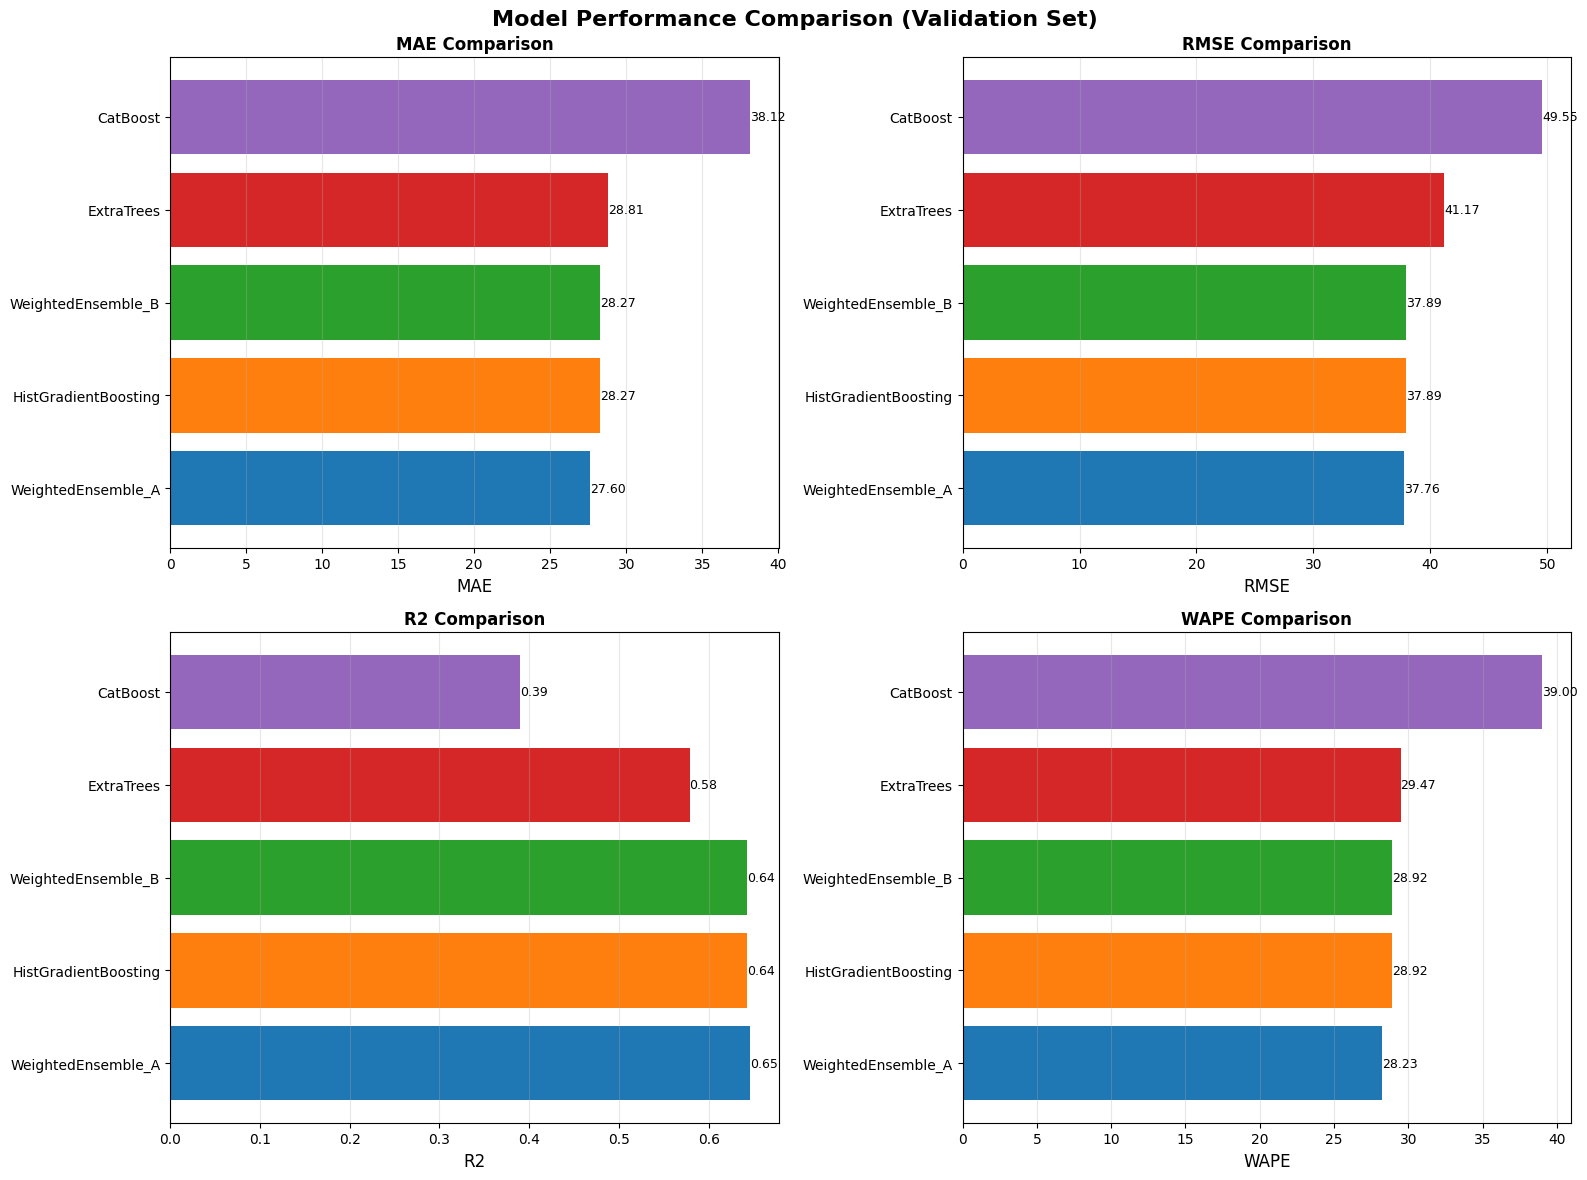


可視化を保存しました: ../output/exp12/model_comparison_validation.png


In [14]:
# ============================================================================
# Visualization: Model Comparison
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Validation結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison (Validation Set)', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'RMSE', 'R2', 'WAPE']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

val_results_sorted = val_results.sort_values('MAE')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    bars = ax.barh(range(len(val_results_sorted)), val_results_sorted[metric], color=colors)
    ax.set_yticks(range(len(val_results_sorted)))
    ax.set_yticklabels(val_results_sorted['model'])
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 値をバーの横に表示
    for i, (bar, val) in enumerate(zip(bars, val_results_sorted[metric])):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
                ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n可視化を保存しました: {output_dir}/model_comparison_validation.png")

---

## Summary

**exp12: 厳密なモデル評価**

### 評価したモデル:
1. **HistGradientBoosting** (hist)
2. **ExtraTrees** (extra)
3. **CatBoost** (catboost)
4. **Weighted Ensemble A** (weightA): Ridge + CatBoost + ExtraTrees + HistGB
5. **Weighted Ensemble B** (weightB): LightGBM + CatBoost + HistGB

### 評価指標:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **R2** (R-squared Score)
- **WAPE** (Weighted Absolute Percentage Error)

### 評価データ:
- **Validation Set**: 訓練時の検証データ
- **Test Set**: 最終的なテストデータ

### 出力ファイル:
1. `model_evaluation_results.csv` - 全モデルの評価結果
2. `model_comparison_validation.png` - Validation結果の可視化